My attempt at the Kaggle challenge on predicting the survival of passengers on the Titanic.

In [1]:
import pandas as pd
import numpy as np
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

C:\Users\david\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_set = pd.read_csv('C:/Users/david/OneDrive/Projects/Tensorflow/DataSets/titanic_train.csv')
test_set = pd.read_csv('C:/Users/david/OneDrive/Projects/Tensorflow/DataSets/titanic_test.csv')

In [3]:
print(train_set.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [4]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


I'm going to remove Name, Ticket, Passengerid and Cabin from the dataset as while there presumably are iinferences that can be drawn from name and ticket I would need additonal data to do so.

In [5]:
train_set = train_set.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis = 1)
test_set = test_set.drop(['Name', 'Ticket', 'Cabin','PassengerId'], axis = 1)

Now I'm going to clean up the data by handling NaNs. First I need to identify is a column is missing data.

In [6]:
def NaN_columns(data):
    cols = data.columns.values
    for i in cols:
        print(i,data[i].isnull().any().any())

In [7]:
print('In Training Set:')
NaN_columns(train_set)
print('\nIn Test Set:')
NaN_columns(test_set)


In Training Set:
Survived False
Pclass False
Sex False
Age True
SibSp False
Parch False
Fare False
Embarked True

In Test Set:
Pclass False
Sex False
Age True
SibSp False
Parch False
Fare True
Embarked False


So, now we need to deal with the unlabelled data for age and embarked. I'm going to start by combining the data sets so we can have better stats when generating averages.

In [8]:
train_set_temp = train_set.drop(['Survived'], axis = 1)
frames = [train_set_temp,test_set]
total_set = pd.concat(frames)

In [9]:
print(train_set_temp.shape,test_set.shape,total_set.shape)

(891, 7) (418, 7) (1309, 7)


In [10]:
port = total_set.Embarked.dropna().mode()[0]
train_set['Age'] = train_set['Age'].fillna(total_set['Age'].dropna().median())
train_set['Embarked'] = train_set['Embarked'].fillna(port)
test_set['Age'] = train_set['Age'].fillna(total_set['Age'].dropna().median())
test_set['Embarked'] = test_set['Embarked'].fillna(port)
test_set['Fare'] = test_set['Fare'].fillna(total_set['Fare'].dropna().mean())

For sanity lets check that the cells I'm filling seem reasonable.

In [11]:
print(port,total_set['Age'].dropna().median(),total_set['Fare'].dropna().mean())

S 28.0 33.2954792813456


Now I'm going to divide the float columns through by the mean. Having all the values being of a similar order should help train the model faster.

In [12]:
train_set['Age'] = train_set['Age']/(total_set['Age'].mean())
test_set['Age'] = test_set['Age']/(test_set['Age'].mean())
train_set['Fare'] = train_set['Fare']/(total_set['Fare'].mean())
test_set['Fare'] = test_set['Fare']/(test_set['Fare'].mean())


Next we need to deal with all the non numerical fields. We can remap these to having numberical values.

In [13]:
sex_map = {'female' : 1, 'male' : 0}
embarked_map = {'S' : 0, 'Q' : 1, 'C' : 2}

#Categorical to Numerical Sex and Embarked, Fill NA with Most Frequent Female and S
train_set['Sex'] = train_set['Sex'].map(sex_map)
train_set['Embarked'] = train_set['Embarked'].map(embarked_map)
test_set['Sex'] = test_set['Sex'].map(sex_map)
test_set['Embarked'] = test_set['Embarked'].map(embarked_map)

Finally for the processing I will setup the sets for training, cross-validation and testing. Where the CV set is taken as 20% of the training set. This is to check for overfitting after we have our model.

In [14]:
train_set.sample(frac=1)
slice_ind=int((len(train_set)*0.8))

arrset=np.array(train_set,dtype='float32')
print(np.shape(arrset))
print (arrset)
arrset= np.column_stack((arrset,arrset[:,0])) #shifting survived to be in the -1th column
arrset=np.delete(arrset,0,1)
print(np.shape(arrset))
print(arrset)

slice_ind=int((len(train_set)*0.8))
train_part=arrset[0:slice_ind]
cv_part=arrset[slice_ind:]


(891, 8)
[[0.         3.         0.         ... 0.         0.21774727 0.        ]
 [1.         1.         1.         ... 0.         2.1409302  2.        ]
 [1.         3.         1.         ... 0.         0.2380203  0.        ]
 ...
 [0.         3.         1.         ... 2.         0.7042998  0.        ]
 [1.         1.         0.         ... 0.         0.9010232  2.        ]
 [0.         3.         0.         ... 0.         0.23276433 1.        ]]
(891, 8)
[[3.         0.         0.7362504  ... 0.21774727 0.         0.        ]
 [1.         1.         1.2717053  ... 2.1409302  2.         1.        ]
 [3.         1.         0.87011415 ... 0.2380203  0.         1.        ]
 ...
 [3.         1.         0.937046   ... 0.7042998  0.         0.        ]
 [1.         0.         0.87011415 ... 0.9010232  2.         1.        ]
 [3.         0.         1.0709097  ... 0.23276433 1.         0.        ]]


Now to import our data into a Tensorflow session.

In [15]:
def parse_data(line):

  # First 4 fields are features, combine into single tensor
  features = tf.reshape(line[:-1], shape=(7,))
  # Last field is the label
  print(type(line))
  label = tf.reshape(line[-1], shape=())
  label=tf.cast(label, tf.int32) #ensure the label is an integer
  return features, label

def parse_testdata(line):
      # First 4 fields are features, combine into single tensor
  features = tf.reshape(line[:], shape=(7,))
  # Last field is the label
  return features

In [16]:

dataset = tf.data.Dataset.from_tensor_slices(train_part)
dataset=dataset.map(parse_data)
dataset = dataset.batch(32)

cvset = tf.data.Dataset.from_tensor_slices(cv_part)
cvset= cvset.map(parse_data)
cvset = cvset.batch(32)



<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


Now to build a model in Keras. Since we don't have a huge amount of data, three layers seems reasonable and if it looks like its overfitting I can always use dropout. I'm also going to define a loss and gradient function. Since are building a classifier I'm going to start by trying softmax. I'm going to just use gradient descent for the gradient function.


In [17]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=(7,)), 
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(2)
])

def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)


For reference I have been tuning the learning rate and have found that a very large value seems to be working well.

In [18]:
# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 301

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in dataset:
    # Optimize the model
    grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

    # Track progress
    epoch_loss_avg(loss(model, x, y))  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))


Epoch 000: Loss: 0.607, Accuracy: 69.242%
Epoch 050: Loss: 0.399, Accuracy: 83.567%
Epoch 100: Loss: 0.383, Accuracy: 83.567%
Epoch 150: Loss: 0.367, Accuracy: 84.551%
Epoch 200: Loss: 0.349, Accuracy: 84.831%
Epoch 250: Loss: 0.340, Accuracy: 84.972%
Epoch 300: Loss: 0.328, Accuracy: 85.955%


Having got an accuracy of 86% which seems reasonable I'm going to compare it against my CV set to check for bias.

In [19]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in cvset:
  prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))


Test set accuracy: 86.034%


With a test set accuracy of 86% this does indicates effectively no bias. I'm going to try implementing dropout which I would usually use to control for bias, but I'm curious to see how it effects the relative predicitive successes.

In [20]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=(7,)),
  tf.keras.layers.Dropout(rate=0.3,seed=34233),  
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(rate=0.3,seed=12343),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(2)
])

In [21]:
# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 301

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in dataset:
    # Optimize the model
    grads = grad(model2, x, y)
    optimizer.apply_gradients(zip(grads, model2.variables),
                              global_step=tf.train.get_or_create_global_step())

    # Track progress
    epoch_loss_avg(loss(model2, x, y))  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model2(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))


Epoch 000: Loss: 0.631, Accuracy: 60.253%
Epoch 050: Loss: 0.398, Accuracy: 83.427%
Epoch 100: Loss: 0.378, Accuracy: 83.848%
Epoch 150: Loss: 0.359, Accuracy: 84.410%
Epoch 200: Loss: 0.343, Accuracy: 86.236%
Epoch 250: Loss: 0.341, Accuracy: 85.674%
Epoch 300: Loss: 0.338, Accuracy: 85.955%


In [22]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in cvset:
  prediction = tf.argmax(model2(x), axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))


Test set accuracy: 86.592%


It doesn't seem to make any real difference so I'm going to leave it in as it will speed up running the code. I'm now going to recombine the CV set with the training set for a larger data set.

In [23]:
datasetfull = tf.data.Dataset.from_tensor_slices(arrset)
datasetfull=datasetfull.map(parse_data)
datasetfull = datasetfull.batch(32)

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

model3 = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=(7,)),
  tf.keras.layers.Dropout(rate=0.3,seed=34233),  
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(rate=0.3,seed=12343),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(2)
])

num_epochs = 301

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in datasetfull:
    # Optimize the model
    grads = grad(model3, x, y)
    optimizer.apply_gradients(zip(grads, model3.variables),
                              global_step=tf.train.get_or_create_global_step())

    # Track progress
    epoch_loss_avg(loss(model3, x, y))  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model3(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))


<class 'tensorflow.python.framework.ops.Tensor'>
Epoch 000: Loss: 0.550, Accuracy: 68.462%
Epoch 050: Loss: 0.355, Accuracy: 86.756%
Epoch 100: Loss: 0.321, Accuracy: 87.991%
Epoch 150: Loss: 0.310, Accuracy: 89.001%
Epoch 200: Loss: 0.304, Accuracy: 89.450%
Epoch 250: Loss: 0.294, Accuracy: 89.787%
Epoch 300: Loss: 0.285, Accuracy: 90.123%


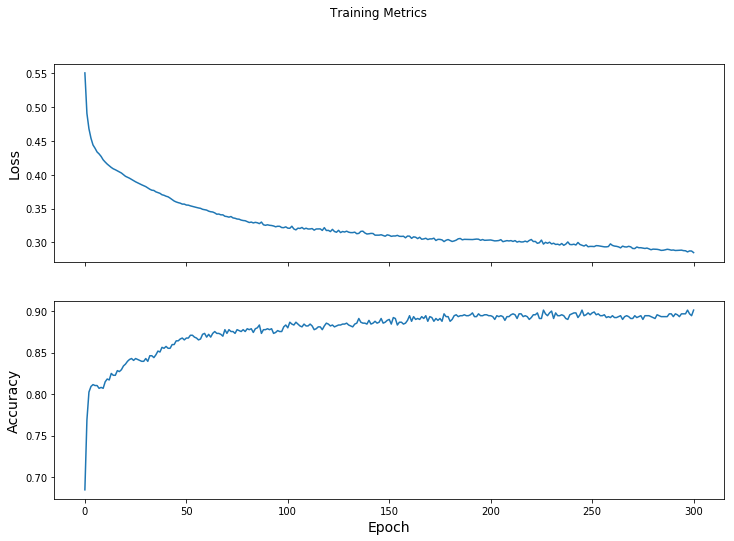

In [24]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()


Now to run my model on the test set and export. I messed around with the column ordering before so I'll need to make sure thats all consistent.

In [25]:
testset=np.array(test_set,dtype='float32')
testset = tf.data.Dataset.from_tensor_slices(testset)
testset=testset.map(parse_testdata)
testset = testset.batch(425)

for x  in testset:
    prediction = tf.argmax(model3(x), axis=1, output_type=tf.int32)

In [26]:
print(prediction)

tf.Tensor(
[0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0
 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1
 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0
 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0
 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 0 0 0 1 0 0 1 0 0 0], shape=(418,), dtype=int32)


In [27]:
prediction = np.asarray(prediction,dtype=int)
p_id=np.linspace(892,1309,418)
prediction=np.column_stack((p_id,prediction))
#print(prediction)
np.savetxt("prediction.csv", prediction, delimiter=",", fmt="%d")